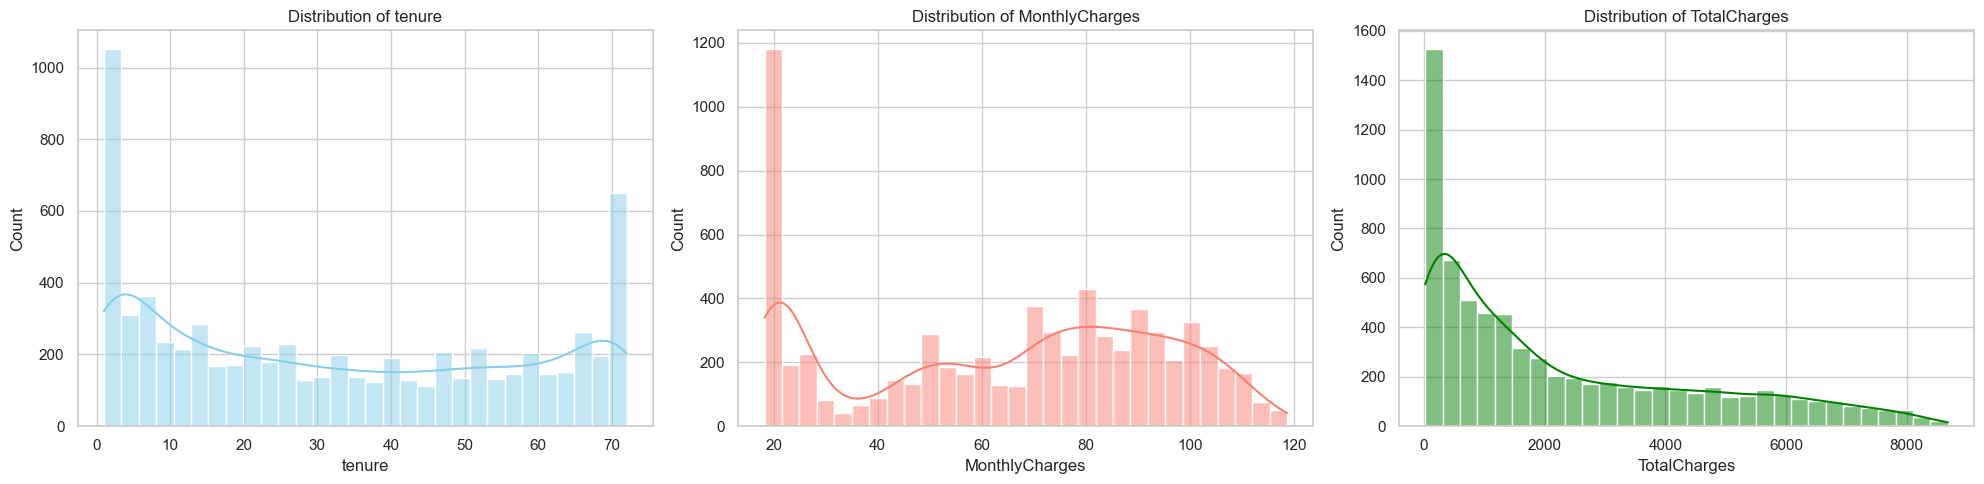

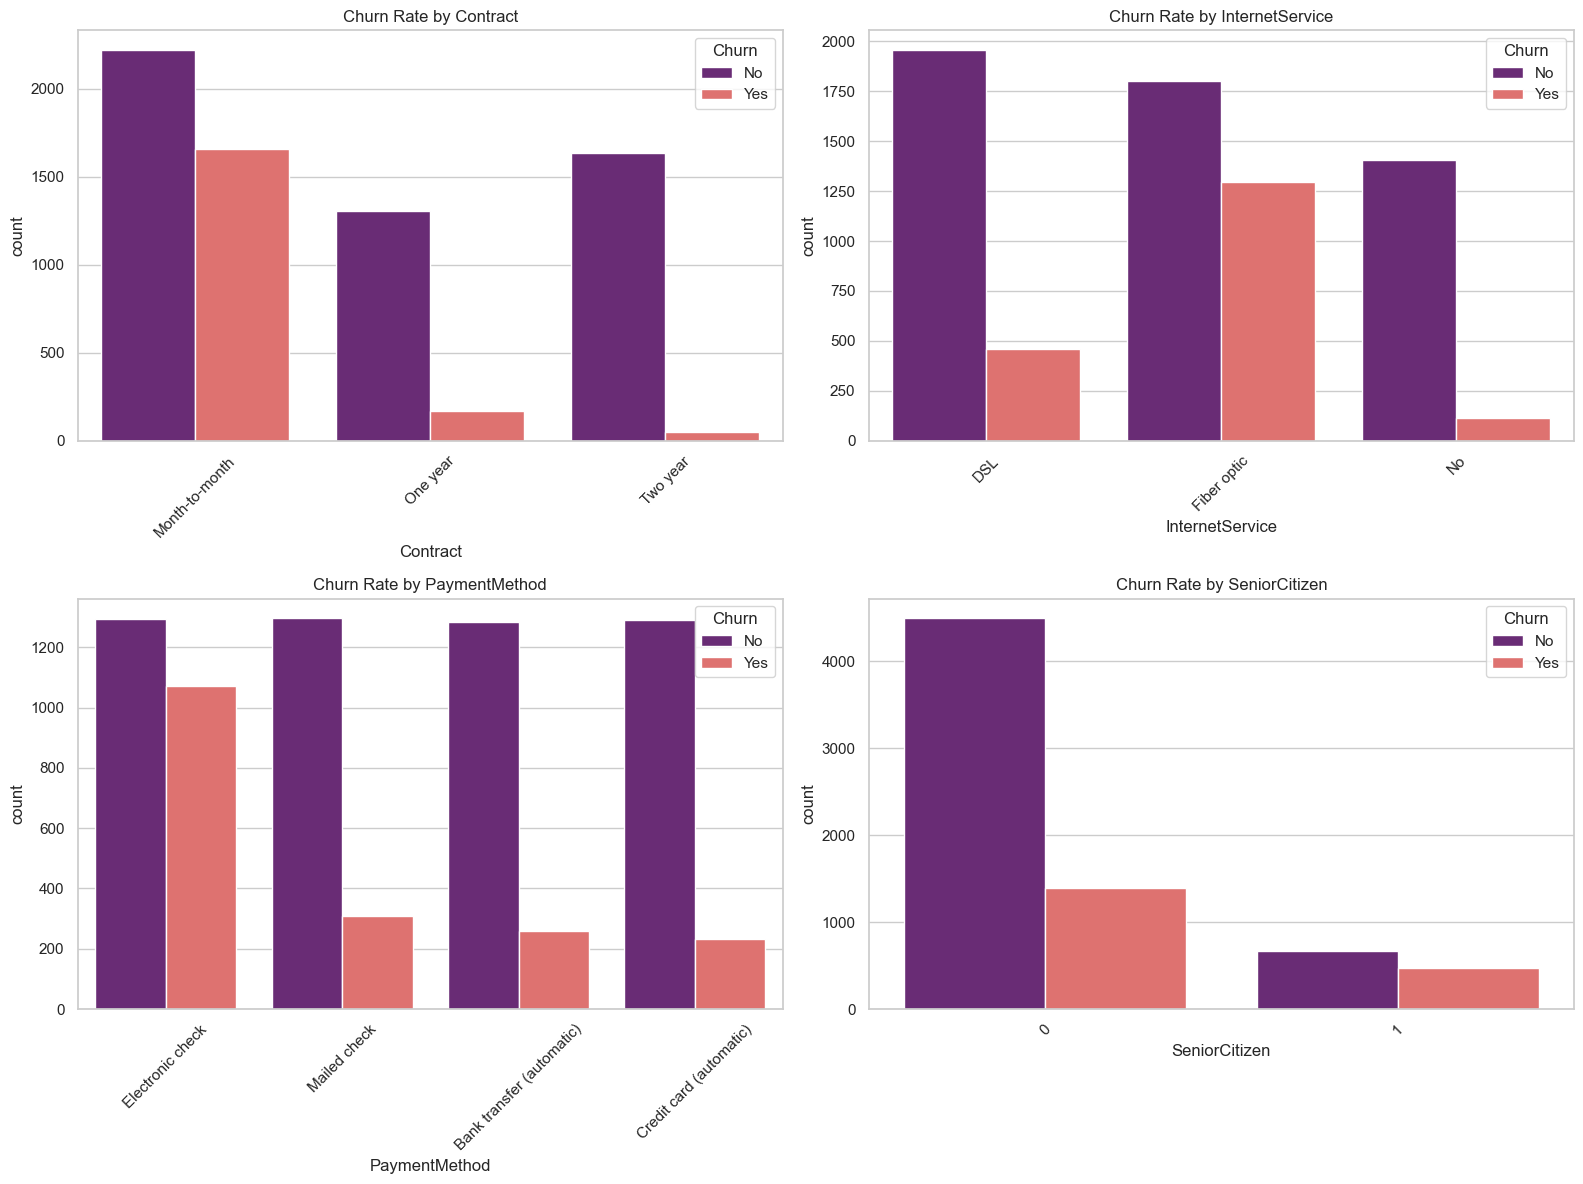

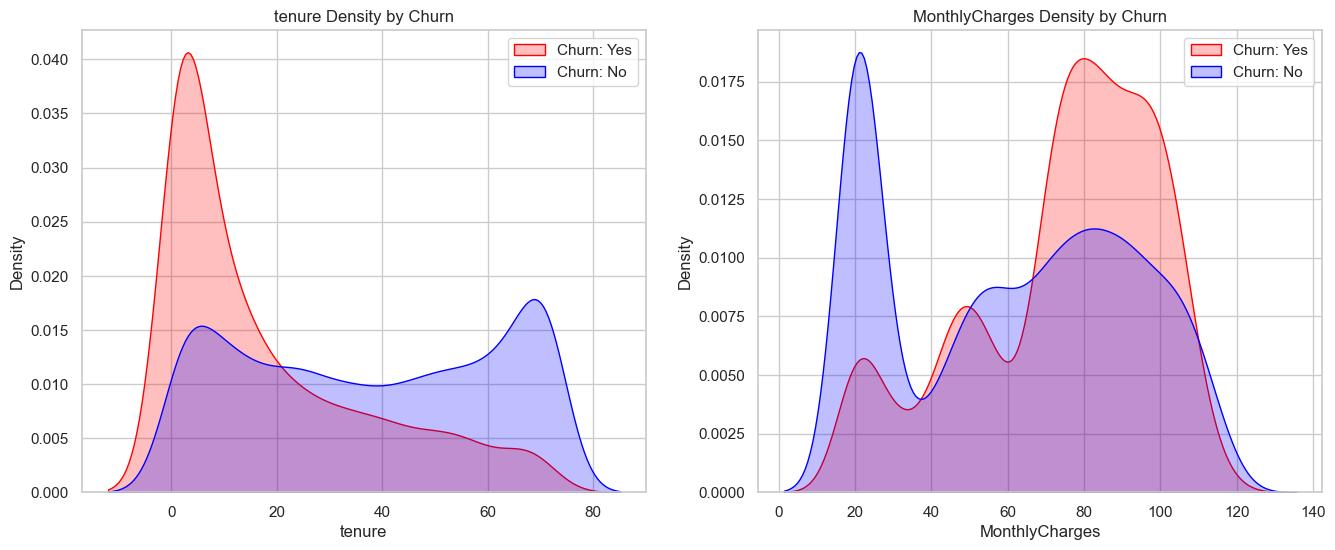

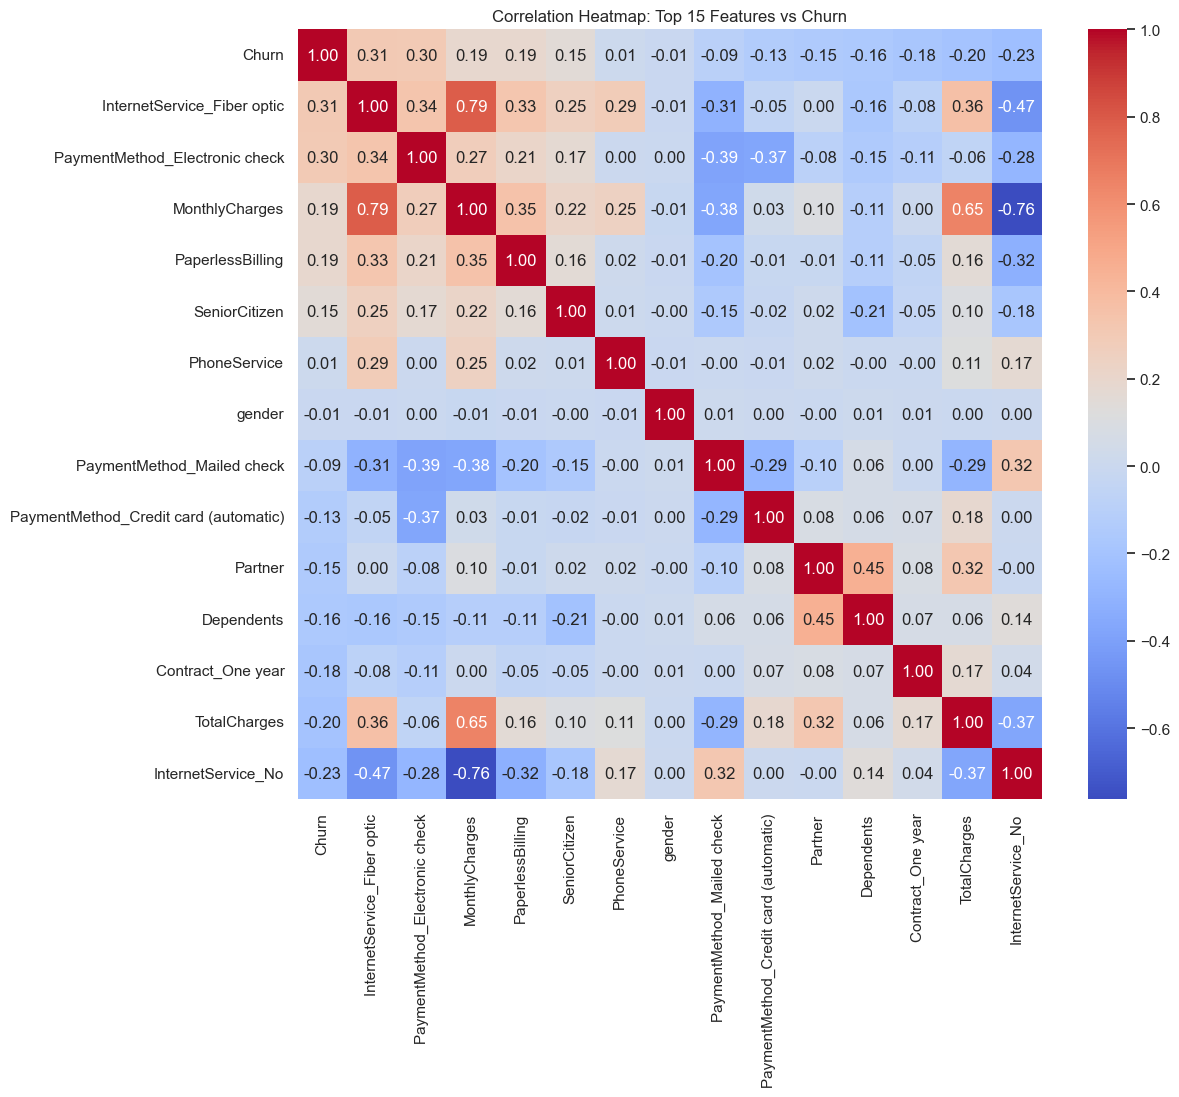

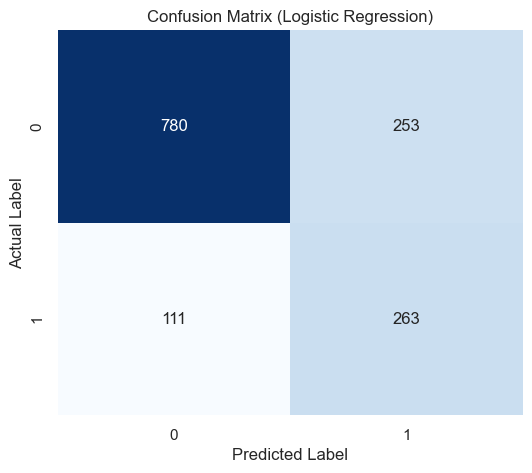

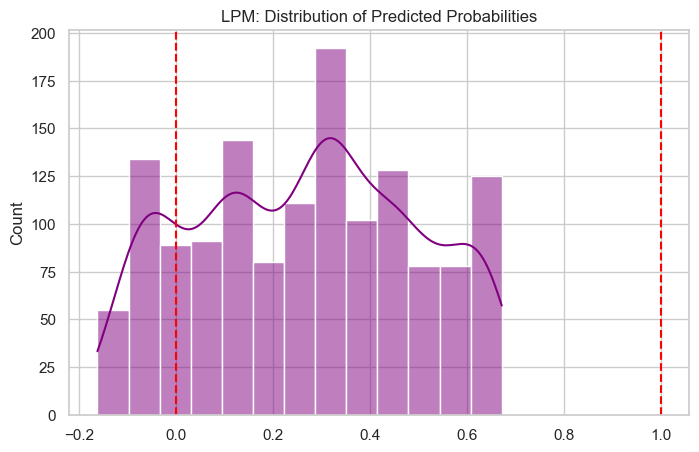

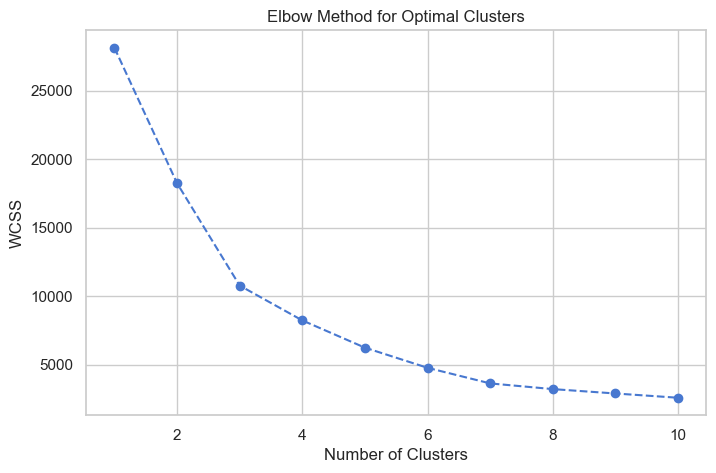

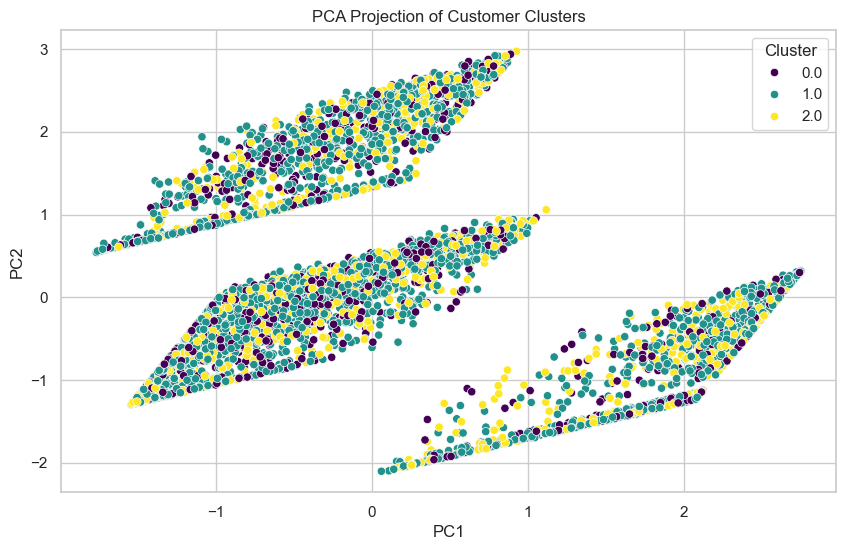


--- Final Cluster Profiles ---
            tenure  MonthlyCharges  Contract_One year  Contract_Two year  \
Cluster                                                                    
0        42.073370       65.079416                1.0                0.0   
1        18.036645       66.398490                0.0                0.0   
2        57.071810       60.872374                0.0                1.0   

            Churn  
Cluster            
0        0.112772  
1        0.427097  
2        0.028487  


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML & Statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score
from imblearn.over_sampling import SMOTE

# Visual Configuration
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

# =========================================================
# 1. DATA LOADING & CONSOLIDATED CLEANING
# =========================================================
df = pd.read_csv('Telco-Customer-Churn.csv')

# Handling 'TotalCharges' string anomaly (Essential for all models)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# Drop CustomerID (Noise)
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# Harmonize Categorical Redundancy
cols_to_fix = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in cols_to_fix:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

# =========================================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# =========================================================

# A. Numerical Frequency Distributions (Univariate)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
colors = ['skyblue', 'salmon', 'green']
for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color=colors[i])
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# B. Categorical Bivariate Analysis
categorical_features = ['Contract', 'InternetService', 'PaymentMethod', 'SeniorCitizen']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='Churn', data=df, ax=axes[i], palette='magma')
    axes[i].set_title(f'Churn Rate by {feature}')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# C. Numerical Density by Churn (KDE Plots)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for i, col in enumerate(['tenure', 'MonthlyCharges']):
    sns.kdeplot(df[df['Churn'] == 'Yes'][col], fill=True, color='red', label='Churn: Yes', ax=axes[i])
    sns.kdeplot(df[df['Churn'] == 'No'][col], fill=True, color='blue', label='Churn: No', ax=axes[i])
    axes[i].set_title(f'{col} Density by Churn')
    axes[i].legend()
plt.show()

# =========================================================
# 3. FEATURE ENGINEERING & TOP-15 HEATMAP
# =========================================================
# Binary Encoding
le = LabelEncoder()
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'gender']
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['Contract', 'PaymentMethod', 'InternetService'], drop_first=True)

# Heatmap Logic: Filter for Top 15 Churn Drivers
corr_matrix = df_encoded.corr(numeric_only=True)
churn_correlation = corr_matrix['Churn'].sort_values(ascending=False)
top_features = churn_correlation.index[:15] 

plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Top 15 Features vs Churn')
plt.savefig('Heatmap.png', dpi=300)
plt.show()

# =========================================================
# 4. LOGISTIC REGRESSION (Classification)
# =========================================================
# Feature Selection
selected_features = ['tenure', 'MonthlyCharges', 'Contract_One year', 'Contract_Two year', 
                     'InternetService_Fiber optic', 'PaymentMethod_Electronic check']
X = df_encoded[selected_features]
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE for Balancing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Model Training & Confusion Matrix
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_res, y_train_res)
y_pred = log_reg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.savefig('confusion matrix.png', dpi=300)
plt.show()

# =========================================================
# 5. LINEAR PROBABILITY MODEL (Regression)
# =========================================================
lpm_model = LinearRegression()
lpm_model.fit(X_train, y_train)
y_pred_lpm = lpm_model.predict(X_test)

# Predict Probabilities Distribution Plot
plt.figure(figsize=(8, 5))
sns.histplot(y_pred_lpm, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.axvline(1, color='red', linestyle='--')
plt.title('LPM: Distribution of Predicted Probabilities')
plt.show()

# =========================================================
# 6. K-MEANS CLUSTERING (Segmentation)
# =========================================================
# Feature Scaling
cluster_features = ['tenure', 'MonthlyCharges', 'Contract_One year', 'Contract_Two year']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded[cluster_features])

# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('Elbow plot.png', dpi=300)
plt.show()

# Final Model (k=3) & PCA Scatter Plot
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
df_encoded['Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df_encoded['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis')
plt.title('PCA Projection of Customer Clusters')
plt.savefig('Clusters.png', dpi=300)
plt.show()

# Print Final Summary
print("\n--- Final Cluster Profiles ---")
print(df_encoded.groupby('Cluster')[cluster_features + ['Churn']].mean())